# Dynamic Systems and Bistable Perception

## Introduction

In the next section we are going to explore some **dynamics** of running a model, including how information flows and is modified over time.  We will be building up to a simple model of bistable perception for a figure that people can readily interpret in two different ways.

![necker cube]({{ assets_url}}/images/necker-cube.png)

Two classic examples of bistable figures are the "Duck Rabbit" seen as either of two animals (but not usually both simultaneously), and the Necker Cube, where the face of the cube that you initially see as closest to you can alternatively be interpreted as farthest away from you.  We are going to work toward a Model of settling on one interpretation of the Necker Cube, after first exploring some simple dynamic models.

## Code Examples

### Installation & Setup

In [1]:
%%capture
!pip install psyneulink

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import psyneulink as pnl

### Dynamics 1: Attractor State

The following code creates a composition with two mechanisms that are mutually connected by weights of -1. The output of one mechanism is multiplied by -1 and given as the input to the next mechanism, in a repeating cycle. We can specify initial input values for each mechanism and watch it evolve over time.  

This particular mechanism will evolve toward stable values of 1 and -1. The values 1 and -1 are determined by the difference between the initial inputs. If the inputs are X and Y, this system will always evolve to $+/-abs[X-Y]/4$ (plus & minus the absolute value of the difference between the two inputs, divided by 4).  Whichever mechanism receives the larger initial input evolves to the positive value, while the smaller initial input evolves to the negative value.     

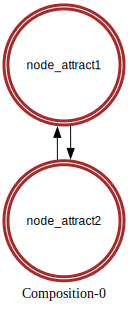

In [3]:
# Create a PsyNeuLink Composition
comp_attract = pnl.Composition()

# Create the first Transfer Mechanism (node)
node_attract1 = pnl.TransferMechanism(
    name='node_attract1',  # Name of the mechanism for identification in graphs and outputs.
    function=pnl.Linear(slope=1, intercept=0),  # Linear function with a slope of 1 and no intercept.
    integrator_mode=True,  # Enables integration of inputs over time (temporal smoothing).
    integration_rate=.5,  # Smoothing factor for integration: balance between current and previous input.
    default_variable=np.zeros((1,)),  # Default input format: a single scalar (vector of size 1).
)

# Create the second Transfer Mechanism (node)
node_attract2 = pnl.TransferMechanism(
    name='node_attract2',
    function=pnl.Linear(slope=1, intercept=0),  # Linear transfer function (identity mapping here).
    integrator_mode=True,  # Temporal smoothing enabled.
    integration_rate=.5,  # Same integration rate as the first node.
    default_variable=np.zeros((1,)),  # Default input format.
)

# Explanation of integration:
# With integrator_mode=True, the current activation is calculated as:
# (1 - integration_rate) * previous_value + integration_rate * current_input
# The mechanism's function is applied to this smoothed value.

# Define the connection weight from node 1 to node 2
connect_a1_a2 = ([-1])  # Weight matrix for mapping from node_attract1 to node_attract2.

# Define the connection weight from node 2 to node 1
connect_a2_a1 = ([-1])  # Weight matrix for mapping from node_attract2 to node_attract1.

# Create a MappingProjection from node_attract1 to node_attract2
weights_a1_a2 = pnl.MappingProjection(
    name='connect_a1_a2',  # Name of the projection for identification.
    matrix=connect_a1_a2,  # Weight matrix for the connection.
)

# Create a MappingProjection from node_attract2 to node_attract1
weights_a2_a1 = pnl.MappingProjection(
    name='connect_a2_a1',  # Name of the projection for identification.
    matrix=connect_a2_a1,  # Weight matrix for the connection.
)

# Add the nodes and projections to the composition as a circular pathway
# This defines a loop where the output of each node influences the other
comp_attract.add_linear_processing_pathway(
    pathway=(node_attract1, weights_a1_a2, node_attract2, weights_a2_a1, node_attract1)
)

# Enable detailed reporting of output for both nodes
node_attract1.reportOutputPref = True  # Output values will be reported during execution.
node_attract2.reportOutputPref = True

# Define inputs for each node over multiple trials
# The inputs will influence the activation and learning behavior of the system
input_a1 = 2  # Initial input to node_attract1.
input_a2 = 6  # Initial input to node_attract2.

input_dict = {
    node_attract1: [input_a1] + [0] * 9,  # Input sequence for node_attract1.
    node_attract2: [input_a2] + [0] * 9   # Input sequence for node_attract2.
}

# Execute the composition for a specified number of trials
comp_attract.run(
    inputs=input_dict,  # Provide the input sequences.
    num_trials=10  # Number of trials to run.
)

# Visualize the graph of the composition
comp_attract.show_graph(output_fmt='jupyter')  # This generates a graph showing the structure of the composition.

We can plot the results over successive time steps to get a clearer sense of how the system evolves over time.  Compare the plot below to your understanding of how the system evolves.

(10, 2)
[[ 1.  3.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]]


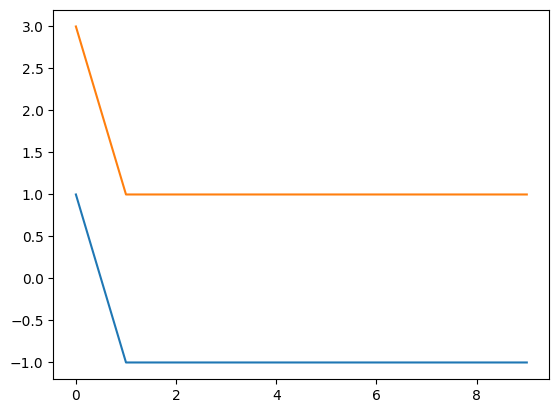

In [4]:
print(np.shape(np.squeeze(comp_attract.results)))
print(np.squeeze(comp_attract.results))
plt.plot(np.squeeze(comp_attract.results))

How did the system evolve over time?

To get a better, we can calculate the activations in each step by hand:

Remember that the activation of each node is calculated as:

$$
\begin{align}
act_{1}(t) &= (1 - integration\_rate) * act_{1}(t-1) + integration\_rate * input_{1} \\
&= (1 - integration\_rate) * act_{1}(t-1) + integration\_rate * (input_{i, external} - act_{2}(t-1))
\end{align}
$$

$$
\begin{align}
act_{1}(t) &= (1 - integration\_rate) * act_{1}(t-1) + integration\_rate * input_{1} \\
&= (1 - integration\_rate) * act_{1}(t-1) + integration\_rate * (input_{i, external} - act_{2}(t-1))
\end{align}
$$


##### Step 1

$$
\begin{align}
act_{1}(1) &= (1 - integration\_rate) * act_{1}(0) + integration\_rate * (input_{i, external} - act_{2}(0)) \\
&= (1 - 0.5) * 0 + 0.5 * (2 - 0) \\
&= 1
\end{align}
$$

$$
\begin{align}
act_{2}(1) &= (1 - integration\_rate) * act_{2}(0) + integration\_rate * (input_{i, external} - act_{1}(0)) \\
&= (1 - 0.5) * 0 + 0.5 * (6 - 0) \\
&= 3
\end{align}
$$

##### Step 2

$$
\begin{align}
act_{1}(2) &= (1 - integration\_rate) * act_{1}(1) + integration\_rate * (input_{i, external} - act_{2}(1)) \\
&= (1 - 0.5) * 1 + 0.5 * (0 - 3) \\
&= -1
\end{align}
$$

$$
\begin{align}
act_{2}(2) &= (1 - integration\_rate) * act_{2}(1) + integration\_rate * (input_{i, external} - act_{1}(1)) \\
&= (1 - 0.5) * 3 + 0.5 * (0 - 1) \\
&= 1
\end{align}
$$

##### Step 3

$$
\begin{align}
act_{1}(3) &= (1 - integration\_rate) * act_{1}(2) + integration\_rate * (input_{i, external} - act_{2}(2)) \\
&= (1 - 0.5) * -1 + 0.5 * (0 - 1) \\
&= -1
\end{align}
$$

$$
\begin{align}
act_{2}(2) &= (1 - integration\_rate) * act_{2}(1) + integration\_rate * (input_{i, external} - act_{1}(1)) \\
&= (1 - 0.5) * 1 + 0.5 * (0 - (-1)) \\
&= 1
\end{align}
$$

So the system has stabilized at $act_{1} = -1$ and $act_{2} = 1$.


Try to predict what happens if we change the input values of `node_attract1` and `node_attract2`.

In the previous cell, we executed the system 10 times (`num_trials = 10`), with initial input values specified as `input_a1 = 6` and `input_a2 = 2`, and all subsequent input values set equal to `0` in the input_dict. What happens if you set all the subsequent input values to `1` instead of `0`?

(10, 2)
[[ 1.   3. ]
 [-0.5  1.5]
 [-0.5  1.5]
 [-0.5  1.5]
 [-0.5  1.5]
 [-0.5  1.5]
 [-0.5  1.5]
 [-0.5  1.5]
 [-0.5  1.5]
 [-0.5  1.5]]


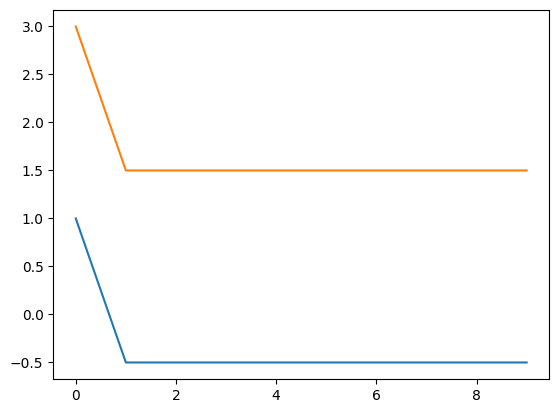

In [7]:
# Reset the composition ensuring that the results are cleared.
comp_attract.reset(clear_results=True)

input_dict = {
    node_attract1: [input_a1] + [1] * 9,  # Input sequence for node_attract1.
    node_attract2: [input_a2] + [1] * 9,  # Input sequence for node_attract2.
}

comp_attract.run(
    inputs=input_dict,
    num_trials=10
)

print(np.shape(np.squeeze(comp_attract.results)))
print(np.squeeze(comp_attract.results))
plt.plot(np.squeeze(comp_attract.results))

### Exercise 1

Explain the behavior of the system when the subsequent input values are set to `1` instead of `0`.



### Solution 1

When the subsequent input values are set to `1` instead of `0` for both attractors, the system will evolve to a stable state where the output of `node_attract1` is `-0.5` and the output of `node_attract2` is `1.5`. With a constant input of `1` for both nodes, the stable state shifts `integration_rate` * `constant_input`. The relative difference between the two nodes remains the same, but the absolute values of the outputs are shifted by the constant input value.


Try to predict what happens if we change the functions in the `TransferMechanisms` from Linear to Logistic (with default parameters, `gain = 1`, `bias = 0`, `offset = 0)`?

(10, 2)
[[0.6791787  0.93991335]
 [0.47627865 0.73796352]
 [0.39736413 0.56943982]
 [0.37919888 0.48527949]
 [0.38010214 0.44545568]
 [0.385259   0.42566125]
 [0.39019962 0.41522241]
 [0.3939239  0.40943333]
 [0.39648311 0.40609888]
 [0.39816431 0.40412669]]


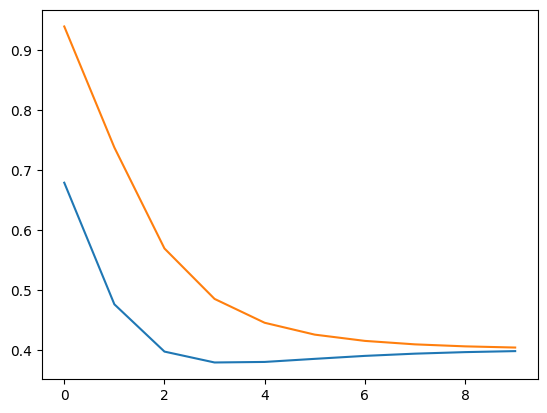

In [36]:
# Create a PsyNeuLink Composition
comp_attract_logistic = pnl.Composition()

# Create the first Transfer Mechanism with Logistic function
node_attract_logistic_1 = pnl.TransferMechanism(
    name='node_attract1',  
    function=pnl.Logistic(gain=1, bias=0, offset=0),  # Logistic function with a gain of 1 and no bias and offset.
    integrator_mode=True,
    integration_rate=.5,
    default_variable=np.zeros((1,)),
)

# Create the second Transfer Mechanism with Logistic function
node_attract_logistic_2 = pnl.TransferMechanism(
    name='node_attract2',
    function=pnl.Logistic(gain=1, bias=0, offset=0),  # Logistic function with a gain of 1 and no bias and offset.
    integrator_mode=True,
    integration_rate=.5,
    default_variable=np.zeros((1,)),
)

# Create the Connection Weights
connect_a1_a2 = ([-1])
connect_a2_a1 = ([-1]) 

# Create the Mapping Projections
weights_logistic_a1_a2 = pnl.MappingProjection(
    name='connect_a1_a2',
    matrix=connect_a1_a2,
)
weights_logistic_a2_a1 = pnl.MappingProjection(
    name='connect_a2_a1',
    matrix=connect_a2_a1,
)

# Add the nodes and projections to the composition
comp_attract_logistic.add_linear_processing_pathway(
    pathway=(node_attract_logistic_1, weights_logistic_a1_a2, node_attract_logistic_2, weights_logistic_a2_a1, node_attract_logistic_1)
)

# Enable detailed reporting of output for both nodes
node_attract_logistic_1.reportOutputPref = True
node_attract_logistic_2.reportOutputPref = True

# Define inputs for each node over multiple trials
input_a1 = 2  # Initial input to node_attract1.
input_a2 = 6  # Initial input to node_attract2.

input_dict = {
    node_attract_logistic_1: [input_a1] + [0] * 9,  # Input sequence for node_attract1.
    node_attract_logistic_2: [input_a2] + [0] * 9,  # Input sequence for node_attract2.
}

# Execute the composition for a specified number of trials
comp_attract_logistic.run(
    inputs=input_dict,
    num_trials=len(input_dict[node_attract_logistic_1])
)

# Plot the output
print(np.shape(np.squeeze(comp_attract_logistic.results)))
print(np.squeeze(comp_attract_logistic.results))
plt.plot(np.squeeze(comp_attract_logistic.results))

### Exercise 2

Write down the equation for activation of the node `node_attract1` with the Logistic function.

### Solution 2

The activation of `node_attract1` with the Logistic function is calculated as:

with the logistic function:

$$
f(x) = \frac{1}{1 + e^{-gain * (x - bias)}} + offset
$$

the activation of `node_attract1` is:

$$
act_{1}(t) = (1 - integration\_rate) * act_{1}(t-1) + integration\_rate * f(input_{1} - act_{2}(t-1))
$$

with gain = 1, bias = 0, and offset = 0:

$$
act_{1}(t) = (1 - integration\_rate) * act_{1}(t-1) + integration\_rate * \frac{1}{1 + e^{-(input_{1} - act_{2}(t-1))}}
$$

</details>

### Dynamics 2: Unstable Feedback Loops

While some systems evolve to fixed attractor states, others will evolve in a runaway cycle that goes continuously up or continuously down. Still others behave chaotically.  If you give the previous system input values that are consistently different the outputs will continuously diverge.
 For example if instead of both inputs being 0 or both being 1 (at each time step after the first one), the inputs are consistently different -- all 0s to node1 and all 1s to node2.  Try running the system with the following input:   

### Exercise 3

You can change the behavior of a system by changing the input values. Think of a way to change the input values so the output will continuously diverge. 

(9, 2)
[[ 0.5   0.  ]
 [ 0.75 -0.25]
 [ 1.   -0.5 ]
 [ 1.25 -0.75]
 [ 1.5  -1.  ]
 [ 1.75 -1.25]
 [ 2.   -1.5 ]
 [ 2.25 -1.75]
 [ 2.5  -2.  ]]


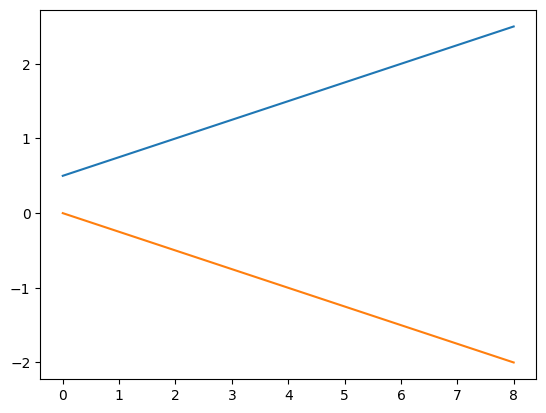

In [14]:
# Reset the composition ensuring that the results are cleared.
comp_attract.reset(clear_results=True)


input_dict = {
    node_attract1: # TODO: Your code here
    node_attract2: # TODO: Your code here
}

# Execute the composition for a specified number of trials
comp_attract.run(
    inputs=input_dict,
    num_trials=len(input_dict[node_attract1])
)

# Plot the output
print(np.shape(np.squeeze(comp_attract.results)))
print(np.squeeze(comp_attract.results))
plt.plot(np.squeeze(comp_attract.results))

### Solution 3

In this case, inputs that are consistently different will cause the outputs to continuously diverge. For example, if we set the input values to `0` for `node_attract1` and `1` for `node_attract2`, the outputs will diverge over time. This is because the system is designed to evolve toward stable states based on the difference between the inputs. If the inputs are consistently different, the outputs will continue to diverge as the system tries to reach a stable state based on the input values.

```python
# Reset the composition ensuring that the results are cleared.
comp_attract.reset(clear_results=True)


input_dict = {
    node_attract1: [0] * 10,  # Input sequence for node_attract1.
    node_attract2: [1] * 10   # Input sequence for node_attract2.
}

# Execute the composition for a specified number of trials
comp_attract.run(
    inputs=input_dict,
    num_trials=len(input_dict[node_attract1])
)

# Plot the output
print(np.shape(np.squeeze(comp_attract.results)))
print(np.squeeze(comp_attract.results))
plt.plot(np.squeeze(comp_attract.results))
```

### Exercise 4

Is there a way to make the outputs diverge for if we use standard Logistic functions (`gain=1, bias=0, offset=0`). Try different weights and inputs to see if you can make the outputs diverge.



(10, 2)
[[0.62245933 0.6791787 ]
 [0.6791787  0.76606606]
 [0.70578503 0.80732231]
 [0.71859439 0.82767589]
 [0.72487028 0.83806756]
 [0.72797545 0.84348561]
 [0.72951978 0.84634083]
 [0.73028987 0.84785201]
 [0.7306744  0.84865249]
 [0.73086653 0.84907606]]


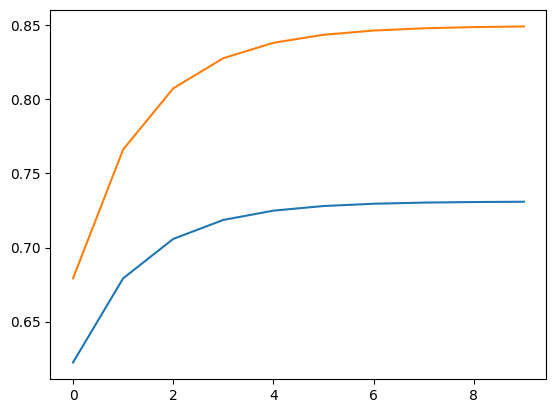

In [35]:
# Create a PsyNeuLink Composition
comp_divergent = pnl.Composition()

# Create the first Transfer Mechanism (node)
node_divergent_1 = pnl.TransferMechanism(
    name='node_attract1',
    function=pnl.Logistic(gain=1, offset=0),  # Logistic function with a slope of 1 and no intercept.
    integrator_mode=True,
    integration_rate=.5,
    default_variable=np.zeros((1,)),
)

# Create the second Transfer Mechanism (node)
node_divergent_2 = pnl.TransferMechanism(
    name='node_attract2',
    function=pnl.Logistic(gain=1, offset=0),
    integrator_mode=True,
    integration_rate=.5,
    default_variable=np.zeros((1,)),
)

# Define the connection weight
connect_divergent_a1_a2 =  # TODO: Your code here

# Define the connection weight from node 2 to node 1
connect_divergent_a2_a1 =  # TODO: Your code here

# Create a MappingProjection from node_attract1 to node_attract2
weights_divergent_a1_a2 = pnl.MappingProjection(
    name='connect_a1_a2',  # Name of the projection for identification.
    matrix=connect_divergent_a1_a2,  # Weight matrix for the connection.
)

# Create a MappingProjection from node_attract2 to node_attract1
weights_divergent_a2_a1 = pnl.MappingProjection(
    name='connect_a2_a1',  # Name of the projection for identification.
    matrix=connect_divergent_a2_a1,  # Weight matrix for the connection.
)

# Add the nodes and projections to the composition as a circular pathway
# This defines a loop where the output of each node influences the other
comp_divergent.add_linear_processing_pathway(
    pathway=(node_divergent_1, weights_divergent_a1_a2, node_divergent_2, weights_divergent_a2_a1, node_divergent_1)
)

# Enable detailed reporting of output for both nodes
node_divergent_1.reportOutputPref = True  # Output values will be reported during execution.
node_divergent_2.reportOutputPref = True

# Define inputs for each node over multiple trials
input_dict = {
    node_divergent_1:  # TODO: Add code here
    node_divergent_2:  # TODO: Add code here
}

# Execute the composition for a specified number of trials
comp_divergent.run(
    inputs=input_dict,  # Provide the input sequences.
    num_trials=10  # Number of trials to run.
)

# Visualize the graph of the composition
print(np.shape(np.squeeze(comp_divergent.results)))
print(np.squeeze(comp_divergent.results))
plt.plot(np.squeeze(comp_divergent.results))

### Solution 4

It is not possible to make the system diverge since the output of the nodes is bounded by the logistic function. The logistic function has a range between 0 and 1, so the outputs of the nodes will always be within this range. Even if you change the weights and inputs, the outputs will not diverge beyond this range.

### Necker Cube Model

The Necker Cube is a 2D drawing with two common 3D interpretations: the faces of the cube that you see in the "front" and "back" can be reversed - this also corresponds to seeing the 3D cube from "above" or "below." With a little practice most people can alternate between seeing these two interpretations. However, almost nobody looks at the figure and spontaneously sees a tangled 3D object with vertices at arbitrary depths, or a 3D "X" or any one of a vast number of other possibilities. How you interpret the vertices seems to be a holistic (Gestalt) process where the local positions of vertices and 3D angles are fixed by a more global interpretation. Could a network of merely local connections give rise to two distinct globally stable interpretations? Put another way, could vertices represented with weights connecting only to a few local neighboring vertices spontaneously move toward either of two global attractor states corresponding to the two interpretations we actually see?



![necker cube connections]({{ assets_url }}/images/necker-cube-connections.png)

You can get a sense from these two figures how we might label and organize a Necker cube model [Note: FUL stands for Front Upper Left, and the other abbreviations are similar.]  Take a few moments to infer as much as you can from the two figures. 

The following figure depicts how we will represent the vertices in our Necker Cube perception model. Think of the red sides as the interpreted "front" of the cube.    

![necker cube fronts]({{ assets_url }}/images/necker-cube-fronts.png)

We'll use 16 nodes, numbered 0 to 15 [because Python indexes arrays starting with 0]. The figure shows that we want activations of these 16 nodes to cluster into two groups, 0-7 and 8-15, and we want these clusters to mutually inhibit each other so that only one cluster is active together at a time, corresponding to one interpretation of the Necker Cube at a time. 

Remember, a connection matrix will have the dimensions 16x16. The entry on [row, column] will be the weight of the connection from the node in the row to the node in the column. For example if the entry on [0, 1] is 1, this means that node 0 has an excitatory connection to node 1. If the entry on [3, 11] is -2, this means that node 3 has an inhibitory connection to node 11.

In the following code, we will build the matrix by specifying the exitatory and inhibitory connections for each vertex in a `build_matrix`. From that, we will generate the necker_matrix with the connection weights. For example, in the line `build_matrix[0,:] = [0, 1, 3, 4, 8]`, you can think of the numbers [0, 1, 3, 4, 8] like this: the first number [0] is a vertex (more specifically, it is a particular 3D interpretation of the spatial position of that vertex), the next three numbers [1, 3, 4] are vertex interpretations that will have excitatory connections to [0], and the last number [8] will have an inhibitory connection to [0]. Now look back at the figure above to fully understand this schematic.  In the left cube 0 is connected by an edge to three other vertices [1, 3, 4]. In the right cube, vertex 8 is in the same position as 0 but has the opposite depth interpretation: 0 and 8 are mutually exclusive interpretations, and their activations should be inversely related using mutual inhibition.

In [38]:
# First, we create the build matrix with the excitatory and inhibitory connections for each vertex in index form
build_matrix = np.zeros((16,5))
build_matrix[0,:] = [0, 1, 3, 4, 8]
build_matrix[1,:] = [1, 0, 2, 5, 9]
build_matrix[2,:] = [2, 1, 3, 6, 10]
build_matrix[3,:] = [3, 0, 2, 7, 11]
build_matrix[4,:] = [4, 5, 7, 0, 12]
build_matrix[5,:] = [5, 4, 6, 1, 13]
build_matrix[6,:] = [6, 5, 7, 2, 14]
build_matrix[7,:] = [7, 4, 6, 3, 15]
build_matrix[8,:] = [8, 9, 11, 12, 0]
build_matrix[9,:] = [9, 8, 10, 13, 1]
build_matrix[10,:] = [10, 9, 11, 14, 2]
build_matrix[11,:] = [11, 8, 10, 15, 3]
build_matrix[12,:] = [12, 13, 15, 8, 4]
build_matrix[13,:] = [13, 12, 14, 9, 5]
build_matrix[14,:] = [14, 13, 15, 10, 6]
build_matrix[15,:] = [15, 12, 14, 11, 7]

# Ensure the matrix is of integer type since we use them as indices
build_matrix = build_matrix.astype(int)
build_matrix

array([[ 0,  1,  3,  4,  8],
       [ 1,  0,  2,  5,  9],
       [ 2,  1,  3,  6, 10],
       [ 3,  0,  2,  7, 11],
       [ 4,  5,  7,  0, 12],
       [ 5,  4,  6,  1, 13],
       [ 6,  5,  7,  2, 14],
       [ 7,  4,  6,  3, 15],
       [ 8,  9, 11, 12,  0],
       [ 9,  8, 10, 13,  1],
       [10,  9, 11, 14,  2],
       [11,  8, 10, 15,  3],
       [12, 13, 15,  8,  4],
       [13, 12, 14,  9,  5],
       [14, 13, 15, 10,  6],
       [15, 12, 14, 11,  7]])

In [39]:
# Now we create the necker_matrix with the connection weights using the build_matrix
necker_matrix = np.zeros((16,16))
necker_matrix = necker_matrix.astype(int)

# Set the excitatory and inhibitory connection weights
excite = 1
inhibit = -2

# Fill the necker_matrix with the connection weights
for x in range(0,16):
    necker_matrix[build_matrix[x,0], build_matrix[x,1]] = excite
    necker_matrix[build_matrix[x,0], build_matrix[x,2]] = excite
    necker_matrix[build_matrix[x,0], build_matrix[x,3]] = excite
    necker_matrix[build_matrix[x,0], build_matrix[x,4]] = inhibit
   
    
necker_matrix

array([[ 0,  1,  0,  1,  1,  0,  0,  0, -2,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  1,  0,  0,  1,  0,  0,  0, -2,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  1,  0,  0,  1,  0,  0,  0, -2,  0,  0,  0,  0,  0],
       [ 1,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0, -2,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0, -2,  0,  0,  0],
       [ 0,  1,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0, -2,  0,  0],
       [ 0,  0,  1,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0, -2,  0],
       [ 0,  0,  0,  1,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0, -2],
       [-2,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  1,  0,  0,  0],
       [ 0, -2,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  1,  0,  0],
       [ 0,  0, -2,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  1,  0],
       [ 0,  0,  0, -2,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0, -2,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  1],
       [ 0,  0,  0,  0,  0, -2,  0,  0,  0,  1,  0,

We can also visualize the matrix similar to the figures in the [Hebbian Learning section]({{ base_url }}/content/Dynamics%20in%20erception/1%20Hebbian%20learning.ipynb).

def plot_correlation_matrix(matrix, mask=None, title="Correlation Matrix", lb=lb, ub=ub):
    """
    Function to plot a correlation matrix with optional masking
    """
    plt.figure()
    plt.title(title)
    
    if mask is not None:
        matrix = np.ma.array(matrix, mask=mask)
    plt.imshow(matrix, cmap='RdBu_r', vmin=lb, vmax=ub)
    plt.colorbar()
    plt.show()

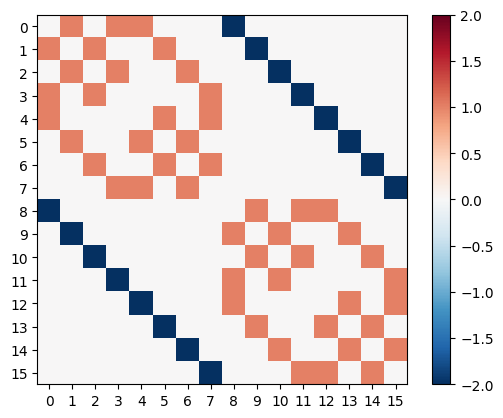

In [43]:
ub=np.max(np.abs(necker_matrix))
lb=-ub

plt.xticks(range(16))  # Rotate labels for better visibility
plt.yticks(range(16))

plt.imshow(necker_matrix, cmap='RdBu_r',vmax=ub)
plt.colorbar()

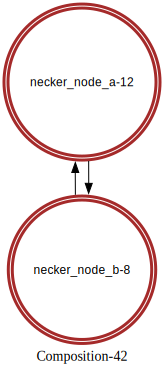

In [167]:
# Create a composition
necker_cube = pnl.Composition()

# Set up the TransferMechanisms with Linear functions
necker_node_a = pnl.TransferMechanism(
    name='necker_node_a',
    input_shapes=16,
    function=pnl.Linear(),
    integrator_mode = True,
    integration_rate = .5,
)

necker_node_b = pnl.TransferMechanism(
    name='necker_node_b',
    input_shapes=16,
    function=pnl.Linear(),
    integrator_mode = True,
    integration_rate = .5,
)

# Set up the connections
weights_A_B = necker_matrix
weights_B_A = necker_matrix

connect_A_B = pnl.MappingProjection(
    name='connect_A_B',
    matrix=weights_A_B,
)

connect_B_A = pnl.MappingProjection(
    name='connect_B_A',
    matrix=weights_B_A,
)

# Add the pathways
necker_cube.add_linear_processing_pathway(pathway = (necker_node_a, connect_A_B, necker_node_b, connect_B_A, necker_node_a))

necker_node_a.reportOutputPref = True
necker_node_b.reportOutputPref = True

# Show the model graph
necker_cube.show_graph(output_fmt = 'jupyter')

In [168]:
trial_length = 10
zero_input = np.zeros([trial_length, 16]) 
necker_input1 = zero_input
necker_input1[0] = np.random.random((1,16))
necker_input2 = zero_input
# necker_input2[0] = np.random.random((1,16))


input_dict = {necker_node_a: necker_input1,
             necker_node_b: necker_input2,
             }

necker_cube.run(input_dict, num_trials = trial_length)

array([[-362.85651231, -295.31561893, -348.51900331, -361.8524576 ,
        -272.54427822, -259.30749891, -258.48583763, -325.63332882,
         336.02510967,  322.71523714,  322.022195  ,  389.1945239 ,
         300.10654539,  232.59048973,  285.71351047,  298.97387155],
       [-362.85651231, -295.31561893, -348.51900331, -361.8524576 ,
        -272.54427822, -259.30749891, -258.48583763, -325.63332882,
         336.02510967,  322.71523714,  322.022195  ,  389.1945239 ,
         300.10654539,  232.59048973,  285.71351047,  298.97387155]])

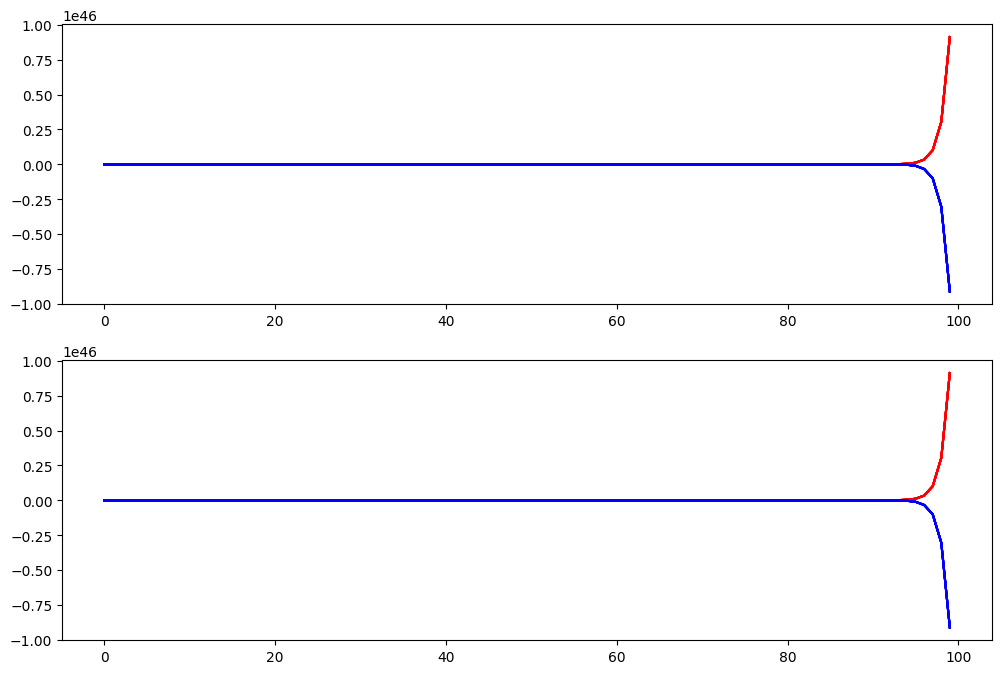

In [170]:
necker_cube.reset(clear_results=True)

np.random.seed(0)  # TODO: Try changing the seed to see different results

trial_length = 100
zero_input = np.zeros([trial_length, 16])
necker_input1 = zero_input
necker_input1[0] = np.random.random((1, 16))
necker_input2 = zero_input
necker_input2[0] = np.random.random((1, 16))

input_dict = {necker_node_a: necker_input1,
              necker_node_b: necker_input2,
              }

necker_cube.run(inputs=input_dict, num_trials=trial_length)

acts = np.squeeze(np.array(necker_cube.results))

f, axes = plt.subplots(2, 1, figsize=(12, 8))
# Plot activation of necker_node_a (input 1-8 in red, input 9-16 in blue)    
axes[0].plot(acts[:, 0, :8], color='red')
axes[0].plot(acts[:, 0, 8:], color='blue')
# Plot activation of necker_node_a (input 1-8 in red, input 9-16 in blue)  
axes[1].plot(acts[:, 1, :8], color='red')
axes[1].plot(acts[:, 1, 8:], color='blue')

### Exercise 5

The Necker Cube perception models presented here are very simple and have lots of room for improvement. You can modify these models to make them better.  For example, over multiple trials the activations run away to very high and very low values. This is unrealistic - How might you fix this problem?

### Solution 5

Instead of linear functions, we can use logistic functions that have a bounded output range. This will prevent the activations from running away to very high and very low values. We can also adjust the integration rate to control the rate at which the activations change over time. By tuning the parameters of the logistic functions and the integration rate, we can create a more stable and realistic model of the Necker Cube perception.

```python
necker_cube_logistic = pnl.Composition()

# Set up the TransferMechanisms with Logistic functions
necker_node_logistic_a = pnl.TransferMechanism(
    name='necker_node_logistic_a',
    input_shapes=16,
    function=pnl.Logistic(),
    integrator_mode = True,
    integration_rate = .5,
)

necker_node_logistic_b = pnl.TransferMechanism(
    name='necker_node_logistic_b',
    input_shapes=16,
    function=pnl.Logistic(),
    integrator_mode = True,
    integration_rate = .5,
)

weights_A_B = necker_matrix
weights_B_A = necker_matrix

connect_A_B = pnl.MappingProjection(
    name='connect_A_B',
    matrix=weights_A_B,
)

connect_B_A = pnl.MappingProjection(
    name='connect_B_A',
    matrix=weights_B_A,
)

necker_cube_logistic.add_linear_processing_pathway(
    pathway = (necker_node_logistic_a, connect_A_B, necker_node_logistic_b, connect_B_A, necker_node_logistic_a)
)


trial_length = 100
zero_input = np.zeros([trial_length, 16])
necker_input1 = zero_input
necker_input1[0] = np.random.random((1, 16))
necker_input2 = zero_input
necker_input2[0] = np.random.random((1, 16))

input_dict = {necker_node_logistic_a: necker_input1,
              necker_node_logistic_b: necker_input2,
              }

necker_cube_logistic.run(inputs=input_dict, num_trials=trial_length)

acts = np.squeeze(np.array(necker_cube_logistic.results))

# Plot the activations of the nodes over time
f, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(acts[:, 0, :8], color='red')
axes[0].plot(acts[:, 0, 8:], color='blue')
axes[1].plot(acts[:, 1, :8], color='red')
axes[1].plot(acts[:, 1, 8:], color='blue')
```


### Exercise 6

![duck_rabbit]({{ assets_url }}/images/duckrabbit.jpeg)

Create your own models of bistable perception for the Duck/Rabbit figure. 

*Requirements*: Your models must include the following 6 features. Ears, Bill, LeftFront, LeftBack, RightFront, RightBack.

Follow (6a - 6b) to create your models.

### Exercise 6a

Create a matrix for the Duck/Rabbit model.

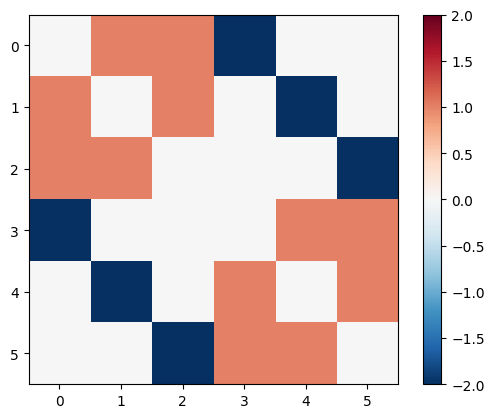

In [251]:
duck_rabbit_matrix =  # TODO: Your code here

ub = np.max(np.abs(duck_rabbit_matrix))
lb = -ub

plt.xticks(range(16))  # Rotate labels for better visibility
plt.yticks(range(16))

plt.imshow(duck_rabbit_matrix, cmap='RdBu_r', vmax=ub)
plt.colorbar()

### Hint 6a

Think about a good feature mapping first. Clustering the features into two groups might be a good start.

### Solution

```python

features = ['ears', 'left_front', 'right_back', 'bill', 'left_back', 'right_front']


# Here, we create the matrix for the Duck/Rabbit model with connections (without the build_matrix)
duck_rabbit_matrix = np.array([
    [ 0,  1,  1, -2,  0,  0],  # Ears(0) exibitory to LeftFront(1) and RightBack(2), inhibitory to Bill(3)
    [ 1,  0,  1,  0, -2,  0],  # LeftFront(1) exibitory to Ears(0) and RightBack(2), inhibitory to LeftBack(4)
    [ 1,  1,  0,  0,  0, -2],  # RightBack(2) exibitory to Ears(0) and LeftFront(1), inhibitory to RightFront(5)
    [-2,  0,  0,  0,  1,  1],  # Bill(3) inhibitory to Ears(0), exibitory to LeftBack(4) and RightFront(5)
    [ 0, -2,  0,  1,  0,  1],  # LeftBack(4) inhibotry to LeftFront(3), exhibitory to Bill(3) and RightFront(5)
    [ 0,  0, -2,  1,  1,  0]   # RightFront(5) inhibitory to RightBack(2), exhibitory to Bill(3) and LeftBack(4)
])                      
```

*Note:* This is just one of multiple possible solutions. The connections can be arranged differently based on the features and their relationships.

### Exercise 6b

Create a model that always arrives one interpretation (depending on a random input).

In [ ]:
# Create a composition
duck_rabbit_comp = pnl.Composition()

# TODO: Your code here

# Show the model graph
trial_length = 100
zero_input = np.zeros([trial_length, 6])
duck_rabbit_input1 = zero_input
duck_rabbit_input1[0] = np.random.random((1, 6))
duck_rabbit_input2 = zero_input
duck_rabbit_input2[0] = np.random.random((1, 6))

input_dict =  # TODO: Your code here

duck_rabbit_comp.run(inputs=input_dict, num_trials=trial_length)

acts = np.squeeze(np.array(duck_rabbit_comp.results))

f, axes = plt.subplots(2, 1, figsize=(12, 8))
# Plot activation of necker_node_a (input 1-8 in red, input 9-16 in blue)    
axes[0].plot(acts[:, 0, :3], color='red')
axes[0].plot(acts[:, 0, 3:], color='blue')
# Plot activation of necker_node_a (input 1-8 in red, input 9-16 in blue)  
axes[1].plot(acts[:, 1, :3], color='red')
axes[1].plot(acts[:, 1, 3:], color='blue')

### Solution 6b         

```python
# Create a composition
duck_rabbit_comp = pnl.Composition()

# Set up the TransferMechanisms with Linear functions
duck_rabbit_node_a = pnl.TransferMechanism(
    name='necker_node_a',
    input_shapes=6,
    function=pnl.Linear(),
    integrator_mode = True,
    integration_rate = .5,
)

duck_rabbit_node_b = pnl.TransferMechanism(
    name='duck_rabbit_node_b',
    input_shapes=6,
    function=pnl.Linear(),
    integrator_mode = True,
    integration_rate = .5,
)

# Set up the connections
weights_a_b = duck_rabbit_matrix
weights_b_a = duck_rabbit_matrix

connect_a_b = pnl.MappingProjection(
    name='connect_a_b',
    matrix=weights_a_b,
)

connect_b_a = pnl.MappingProjection(
    name='connect_b_a',
    matrix=weights_b_a,
)

# Add the pathways
duck_rabbit_comp.add_linear_processing_pathway(pathway = (duck_rabbit_node_a, connect_a_b, duck_rabbit_node_b, connect_b_a, duck_rabbit_node_a))


# Show the model graph
trial_length = 100
zero_input = np.zeros([trial_length, 6])
duck_rabbit_input1 = zero_input
duck_rabbit_input1[0] = np.random.random((1, 6))
duck_rabbit_input2 = zero_input
duck_rabbit_input2[0] = np.random.random((1, 6))

input_dict = {duck_rabbit_node_a: duck_rabbit_input1,
              duck_rabbit_node_b: duck_rabbit_input2,
              }

duck_rabbit_comp.run(inputs=input_dict, num_trials=trial_length)

acts = np.squeeze(np.array(duck_rabbit_comp.results))

f, axes = plt.subplots(2, 1, figsize=(12, 8))
# Plot activation of necker_node_a (input 1-8 in red, input 9-16 in blue)    
axes[0].plot(acts[:, 0, :3], color='red')
axes[0].plot(acts[:, 0, 3:], color='blue')
# Plot activation of necker_node_a (input 1-8 in red, input 9-16 in blue)  
axes[1].plot(acts[:, 1, :3], color='red')
axes[1].plot(acts[:, 1, 3:], color='blue')
```

### Exercise 6c

When looking at some bistable figures, after a certain amount of time your interpretation spontaneously flips to the opposite of what you previously saw.

Create a model that oscillates between the two interpretations.

### Hint 6c

A simple way to introduce oscillations is to use negative feedback and non-linearity. 

### Solution 6c       

```python
# Create a composition
duck_rabbit_comp = pnl.Composition()

# Set up the TransferMechanisms with Linear functions
duck_rabbit_node_a = pnl.TransferMechanism(
    name='necker_node_a',
    input_shapes=6,
    function=pnl.Logistic(), # Here, we use the Logistic function to introduce non-linearity
    integrator_mode = True,
    integration_rate = .5,
)

duck_rabbit_node_b = pnl.TransferMechanism(
    name='duck_rabbit_node_b',
    input_shapes=6,
    function=pnl.Linear(),
    integrator_mode = True,
    integration_rate = .5,
)

# Set up the connections
weights_a_b = duck_rabbit_matrix
weights_b_a = - 10 * duck_rabbit_matrix # Here we use a negative feedback to create oscillations

connect_a_b = pnl.MappingProjection(
    name='connect_a_b',
    matrix=weights_a_b,
)

connect_b_a = pnl.MappingProjection(
    name='connect_b_a',
    matrix=weights_b_a,
)

# Add the pathways
duck_rabbit_comp.add_linear_processing_pathway(pathway = (duck_rabbit_node_a, connect_a_b, duck_rabbit_node_b, connect_b_a, duck_rabbit_node_a))


# Show the model graph
trial_length = 100
zero_input = np.zeros([trial_length, 6])
duck_rabbit_input1 = zero_input
duck_rabbit_input1[0] = np.random.random((1, 6))
duck_rabbit_input2 = zero_input
duck_rabbit_input2[0] = np.random.random((1, 6))

input_dict = {duck_rabbit_node_a: duck_rabbit_input1,
              duck_rabbit_node_b: duck_rabbit_input2,
              }

duck_rabbit_comp.run(inputs=input_dict, num_trials=trial_length)

acts = np.squeeze(np.array(duck_rabbit_comp.results))

f, axes = plt.subplots(2, 1, figsize=(12, 8))
# Plot activation of necker_node_a (input 1-8 in red, input 9-16 in blue)    
axes[0].plot(acts[:, 0, :3], color='red')
axes[0].plot(acts[:, 0, 3:], color='blue')
# Plot activation of necker_node_a (input 1-8 in red, input 9-16 in blue)  
axes[1].plot(acts[:, 1, :3], color='red')
axes[1].plot(acts[:, 1, 3:], color='blue')
```

*Note:* This is just one out of many solution (with minimal changes from the original code). The oscillations can be created in many different ways, and the model can be improved in many ways. 